In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('Variable_final.csv')

df = df.astype("category")  # Convert all columns to categorical type
print(df.dtypes)  # Display the data types of all variables



SEX               category
_AGE_GROUP        category
_RACEGR3          category
_EDUCA_GROUP      category
_INCOM_GROUP      category
_SMOKER3_GROUP    category
_BMI5CAT          category
_FRTLT1A          category
_VEGLT1A          category
_TOTINDA          category
_RFBING5          category
_ECIGSTS_GROUP    category
_PHYS14D          category
_MENT14D          category
CHECKUP1_GROUP    category
_LTASTH1          category
dtype: object


In [2]:
df['_LTASTH1'] = df['_LTASTH1'].map({1.0: 0, 2.0: 1})  # Map values: 1.0 to 0, 2.0 to 1
df['_LTASTH1'] = df['_LTASTH1'].astype(int)  # Convert to integer type

print(df['_LTASTH1'].dtype)  # Check the data type
print(df['_LTASTH1'].value_counts())  # Display value counts

print(df['_LTASTH1'].isna().sum())  # Check the number of missing values
print(df['_LTASTH1'].unique())  # Display unique values


int32
0    264659
1     42549
Name: _LTASTH1, dtype: int64
0
[0 1]


In [3]:
import itertools
import statsmodels.formula.api as smf

# Define Variable
demographic_vars = ["C(SEX)", "C(_AGE_GROUP)", "C(_RACEGR3)", "C(_EDUCA_GROUP)", "C(_INCOM_GROUP)"]
lifestyle_vars = ["C(_SMOKER3_GROUP)", "C(_BMI5CAT)", "C(_FRTLT1A)", "C(_VEGLT1A)", 
                  "C(_TOTINDA)", "C(_RFBING5)", "C(_ECIGSTS_GROUP)", "C(_PHYS14D)", 
                  "C(_MENT14D)", "C(CHECKUP1_GROUP)"]
all_vars = demographic_vars + lifestyle_vars


## top20 interaction creation

In [4]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from IPython.display import display

# Combine all variable lists
all_vars_list = lifestyle_vars + demographic_vars

# Clean all variable lists and center numerical variables (categorical variables remain unchanged)
all_vars_centered = []
for var in all_vars_list:
    if var.startswith("C(") and var.endswith(")"):  # Process categorical variables
        var_clean = var[2:-1]
        all_vars_centered.append(f"C({var_clean})")
    else:
        var_clean = var
        if pd.api.types.is_numeric_dtype(df[var_clean]):  # Center numerical variables
            centered_var = var_clean + "_centered"
            df[centered_var] = df[var_clean] - df[var_clean].mean()
            all_vars_centered.append(centered_var)
        else:
            all_vars_centered.append(var_clean)

# Generate interaction terms
def generate_interaction_terms(vars_list):
    return ["{}:{}".format(a, b) for a, b in itertools.combinations(vars_list, 2)]

# Construct the correct regression formula (including main effects + interaction terms)
formula_interactions = "_LTASTH1 ~ " + " + ".join(generate_interaction_terms(all_vars_centered))

# Run logistic regression, controlling for confounding factors
model_interactions = smf.logit(formula=formula_interactions, data=df).fit(cov_type='HC0')

# Construct results DataFrame and calculate OR, 95% confidence intervals, and Adjusted OR
summary_df = pd.DataFrame({
    "Variable": model_interactions.params.index,
    "Coefficient": model_interactions.params.values,
    "Std Err": model_interactions.bse.values,
    "z-score": model_interactions.tvalues,
    "p-value": model_interactions.pvalues
})
summary_df["OR"] = np.exp(summary_df["Coefficient"])  # Calculate odds ratio (OR)
ci = model_interactions.conf_int()
summary_df["2.5% CI"] = np.exp(ci.iloc[:, 0])
summary_df["97.5% CI"] = np.exp(ci.iloc[:, 1])

# ✅ **Calculate Adjusted OR to measure deviation from 1 consistently**
summary_df["Adjusted OR"] = summary_df["OR"].apply(lambda x: max(x, 1/x))

# ✅ **Filter all interaction terms (variables containing ":")**
interaction_df = summary_df[summary_df["Variable"].str.contains(":")]

# ✅ **Select the top 20 interaction terms based on Adjusted OR**
top_20_interactions = interaction_df.nlargest(20, "Adjusted OR")

# ✅ **Final report DataFrame, sorted by Adjusted OR**
report_df = top_20_interactions[["Variable", "OR", "2.5% CI", "97.5% CI", "p-value", "Adjusted OR"]]
report_df[["OR", "2.5% CI", "97.5% CI", "p-value", "Adjusted OR"]] = report_df[["OR", "2.5% CI", "97.5% CI", "p-value", "Adjusted OR"]].round(3)
report_df = report_df.set_index("Variable").sort_values(by="Adjusted OR", ascending=False)  # ✅ **Sorting**

print("Top 20 interaction terms selected based on Adjusted OR (for reporting):")
display(report_df)



Optimization terminated successfully.
         Current function value: 0.379701
         Iterations 7
Top 20 interaction terms selected based on Adjusted OR (for reporting):


d:\Anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,OR,2.5% CI,97.5% CI,p-value,Adjusted OR
Variable,,,,,
C(_SMOKER3_GROUP)[1]:C(_AGE_GROUP)[T.3],0.403,0.279,0.580,0.000,2.484
C(_SMOKER3_GROUP)[3]:C(_AGE_GROUP)[T.3],0.475,0.326,0.692,0.000,2.105
C(_SMOKER3_GROUP)[2]:C(_AGE_GROUP)[T.3],0.488,0.336,0.709,0.000,2.049
C(_SMOKER3_GROUP)[1]:C(_INCOM_GROUP)[T.3],0.497,0.354,0.697,0.000,2.013
C(_SMOKER3_GROUP)[2]:C(CHECKUP1_GROUP)[T.2],0.514,0.392,0.672,0.000,1.947
C(_SMOKER3_GROUP)[3]:C(CHECKUP1_GROUP)[T.2],0.524,0.400,0.687,0.000,1.907
C(_SMOKER3_GROUP)[1]:C(CHECKUP1_GROUP)[T.2],0.528,0.406,0.686,0.000,1.895
C(_SMOKER3_GROUP)[1]:C(_PHYS14D)[T.2.0],1.884,1.419,2.500,0.000,1.884
C(_SMOKER3_GROUP)[3]:C(_PHYS14D)[T.2.0],1.799,1.347,2.402,0.000,1.799


## Define AIC

In [5]:
# 定义基于 AIC 的双向逐步回归函数
def stepwise_selection(data, response, predictors, initial_list=[], verbose=True):
    """
    双向逐步回归（基于 AIC）:
      参数:
        data: 包含数据的 DataFrame
        response: 响应变量名称（字符串）
        predictors: 候选自变量列表
        initial_list: 初始模型中的变量（列表）
        verbose: 是否打印每一步信息
      返回:
        (最终选入的变量列表, 最终模型的 AIC)
    """
    included = list(initial_list)
    # 初始模型 AIC
    formula = "{} ~ {}".format(response, " + ".join(included) if included else "1")
    best_model = smf.logit(formula, data).fit(disp=0)
    best_aic = best_model.aic

    while True:
        changed = False
        
        # forward step: 尝试添加变量
        excluded = list(set(predictors) - set(included))
        aic_with_candidates = {}
        for new_var in excluded:
            formula = "{} ~ {}".format(response, " + ".join(included + [new_var]))
            try:
                model = smf.logit(formula, data).fit(disp=0)
                aic_with_candidates[new_var] = model.aic
            except Exception:
                continue
        if aic_with_candidates:
            best_candidate = min(aic_with_candidates, key=aic_with_candidates.get)
            candidate_aic = aic_with_candidates[best_candidate]
            if candidate_aic < best_aic:
                included.append(best_candidate)
                best_aic = candidate_aic
                changed = True
                if verbose:
                    print("添加 {:30} AIC: {:.6f}".format(best_candidate, candidate_aic))
        
        # backward step: 尝试删除变量
        if included:
            aic_without_candidates = {}
            for var in included:
                temp = list(included)
                temp.remove(var)
                formula = "{} ~ {}".format(response, " + ".join(temp) if temp else "1")
                try:
                    model = smf.logit(formula, data).fit(disp=0)
                    aic_without_candidates[var] = model.aic
                except Exception:
                    continue
            if aic_without_candidates:
                worst_candidate = min(aic_without_candidates, key=aic_without_candidates.get)
                removal_aic = aic_without_candidates[worst_candidate]
                if removal_aic < best_aic:
                    included.remove(worst_candidate)
                    best_aic = removal_aic
                    changed = True
                    if verbose:
                        print("删除 {:30} AIC: {:.6f}".format(worst_candidate, removal_aic))
        
        if not changed:
            break

    return included, best_aic

In [6]:
# 1. **构造最终候选变量列表**
final_candidate_predictors = demographic_vars + lifestyle_vars + top_20_interactions["Variable"].tolist()

# 2. **使用 StepAIC 进行变量筛选**
# 初始模型包含所有主效应（人口统计 + 生活方式）
selected_vars, final_aic = stepwise_selection(df, "_LTASTH1", final_candidate_predictors, initial_list=demographic_vars + lifestyle_vars, verbose=True)

print("\nStepAIC 筛选后保留的变量：", selected_vars)
print("最终模型 AIC: ", final_aic)

# 3. **拟合最终模型**
final_formula = "_LTASTH1 ~ " + " + ".join(selected_vars)
final_model = smf.logit(final_formula, data=df).fit(cov_type='HC0', disp=0)

# 4. **输出最终模型结果**
print("\n最终模型拟合结果：")
print(final_model.summary())

删除 C(_TOTINDA)                    AIC: 234740.875411
删除 C(_FRTLT1A)                    AIC: 234740.121652

StepAIC 筛选后保留的变量： ['C(SEX)', 'C(_AGE_GROUP)', 'C(_RACEGR3)', 'C(_EDUCA_GROUP)', 'C(_INCOM_GROUP)', 'C(_SMOKER3_GROUP)', 'C(_BMI5CAT)', 'C(_VEGLT1A)', 'C(_RFBING5)', 'C(_ECIGSTS_GROUP)', 'C(_PHYS14D)', 'C(_MENT14D)', 'C(CHECKUP1_GROUP)']
最终模型 AIC:  234740.12165176062

最终模型拟合结果：
                           Logit Regression Results                           
Dep. Variable:               _LTASTH1   No. Observations:               307208
Model:                          Logit   Df Residuals:                   307183
Method:                           MLE   Df Model:                           24
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                 0.05038
Time:                        01:03:14   Log-Likelihood:            -1.1735e+05
converged:                       True   LL-Null:                   -1.2357e+05
Covariance Type:                  HC0   LLR p-value:          

## 基础模型

Confusion Matrix:
[[264544    115]
 [ 42432    117]]
Sensitivity: 0.002749770852428964
Specificity: 0.9995654785969871
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93    264659
           1       0.50      0.00      0.01     42549

    accuracy                           0.86    307208
   macro avg       0.68      0.50      0.47    307208
weighted avg       0.81      0.86      0.80    307208

AUC: 0.6588902814203732


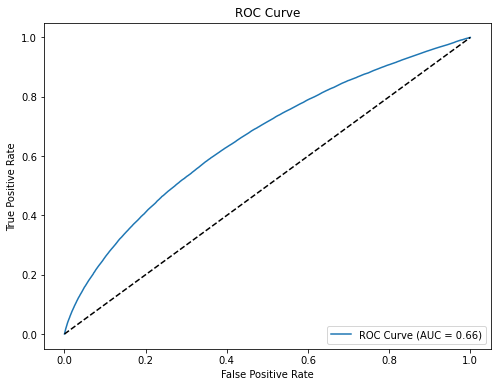

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score


# Compute predicted probabilities from the logistic regression model
df['pred_prob'] = final_model.predict(df)

# Set a classification threshold (0.5 by default)
df['pred_class'] = (df['pred_prob'] >= 0.5).astype(int)

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(df['_LTASTH1'], df['pred_class'])
print("Confusion Matrix:")
print(cm)

# Extract TN, FP, FN, TP from the confusion matrix
TN, FP, FN, TP = cm.ravel()

# Calculate sensitivity (True Positive Rate) and specificity (True Negative Rate)
sensitivity = TP / (TP + FN)  # Sensitivity: proportion of actual positives correctly identified
specificity = TN / (TN + FP)  # Specificity: proportion of actual negatives correctly identified

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Generate a classification report including precision, recall, and F1 score
print("Classification Report:")
print(classification_report(df['_LTASTH1'], df['pred_class']))

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(df['_LTASTH1'], df['pred_prob'])
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## 调整Threshold

Optimal Threshold (based on Youden's Index): 0.1378
Confusion Matrix at Optimal Threshold:
[[172764  91895]
 [ 17846  24703]]
Sensitivity: 0.5806
Specificity: 0.6528
Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76    264659
           1       0.21      0.58      0.31     42549

    accuracy                           0.64    307208
   macro avg       0.56      0.62      0.53    307208
weighted avg       0.81      0.64      0.70    307208

AUC: 0.6589


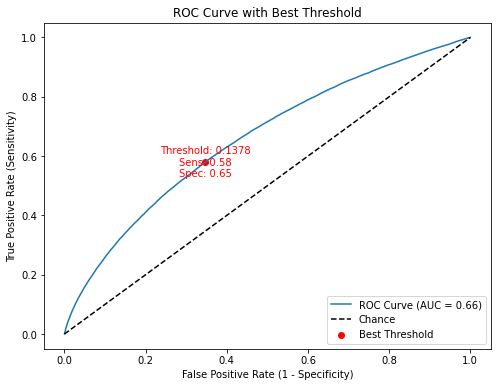

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# 1. Compute predicted probabilities (Ensure final_model is fitted and df contains all required variables)
df['pred_prob'] = final_model.predict(df)

# 2. Compute ROC curve data
fpr, tpr, thresholds = roc_curve(df['_LTASTH1'], df['pred_prob'])

# 3. Compute Youden's index: J = sensitivity - (1 - specificity) = tpr - fpr
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print("Optimal Threshold (based on Youden's Index): {:.4f}".format(best_threshold))

# 4. Generate predicted class labels using the optimal threshold
df['pred_class_optimal'] = (df['pred_prob'] >= best_threshold).astype(int)

# 5. Compute confusion matrix and extract TN, FP, FN, TP to calculate sensitivity and specificity
cm_optimal = confusion_matrix(df['_LTASTH1'], df['pred_class_optimal'])
print("Confusion Matrix at Optimal Threshold:")
print(cm_optimal)

TN, FP, FN, TP = cm_optimal.ravel()
sensitivity = TP / (TP + FN)  # Sensitivity (True Positive Rate)
specificity = TN / (TN + FP)  # Specificity (True Negative Rate)
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Compute and display AUC value
roc_auc = auc(fpr, tpr)


print("Classification Report at Optimal Threshold:")
print(classification_report(df['_LTASTH1'], df['pred_class_optimal']))

print("AUC: {:.4f}".format(roc_auc))

# 6. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label="Chance")

# Mark the optimal threshold point: corresponding (FPR, TPR) is (fpr[ix], tpr[ix])
plt.scatter(fpr[ix], tpr[ix], color='red', label='Best Threshold')
plt.text(fpr[ix], tpr[ix]-0.05, 
         'Threshold: {:.4f}\nSens: {:.2f}\nSpec: {:.2f}'.format(best_threshold, sensitivity, specificity),
         horizontalalignment='center', color='red', fontsize=10)

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve with Best Threshold")
plt.legend(loc="lower right")
plt.show()


Original training set distribution:
0    185261
1     29784
Name: _LTASTH1, dtype: int64

Resampled training set distribution:
0    52931
1    37052
Name: _LTASTH1, dtype: int64

Confusion Matrix:
[[52900 26498]
 [ 5708  7057]]
Sensitivity (Recall for positive class): 0.5528397963180572
Specificity: 0.6662636338446812

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77     79398
           1       0.21      0.55      0.30     12765

    accuracy                           0.65     92163
   macro avg       0.56      0.61      0.54     92163
weighted avg       0.81      0.65      0.70     92163

AUC: 0.6489685643377501


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


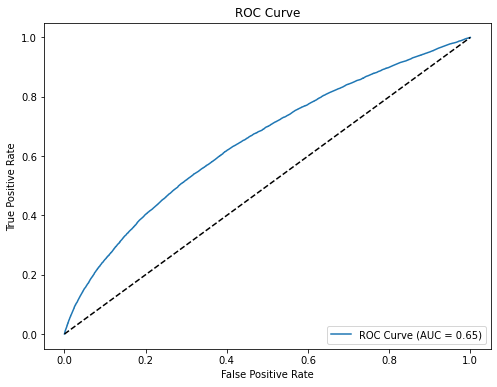

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# -------------------------------------------------------------------------
# Step 1: Prepare the data based on the final predictors (ensure column names match the DataFrame)
# -------------------------------------------------------------------------
final_predictors = [
    "SEX", "_AGE_GROUP", "_RACEGR3", "_EDUCA_GROUP", "_INCOM_GROUP",
    "_SMOKER3_GROUP", "_BMI5CAT", "_FRTLT1A", "_VEGLT1A", 
    "_TOTINDA", "_RFBING5", "_ECIGSTS_GROUP", "_PHYS14D", 
    "_MENT14D", "CHECKUP1_GROUP"
]

# Create a subset including only the final predictors and the target variable.
# Drop rows with missing values in these columns if any remain.
df_final = df[final_predictors + ["_LTASTH1"]].dropna()

# -------------------------------------------------------------------------
# Step 2: Split the data into training and testing sets (stratified).
# -------------------------------------------------------------------------
X = df_final.drop(columns=["_LTASTH1"])
y = df_final["_LTASTH1"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------------------------------------------------------
# Step 3: Define an imputer to handle any missing values and a resampling pipeline.
# -------------------------------------------------------------------------
# For categorical data, it's common to impute with the most frequent value.
imputer = SimpleImputer(strategy='most_frequent')

# Define resampling strategies: SMOTE for oversampling and RandomUnderSampler for undersampling.
over = SMOTE(sampling_strategy=0.2, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)

# Create a pipeline that first imputes missing values, then applies SMOTE and undersampling.
resample_pipeline = Pipeline(steps=[
    ('imputer', imputer),
    ('over', over),
    ('under', under)
])

# Resample the training data
X_train_res, y_train_res = resample_pipeline.fit_resample(X_train, y_train)

print("Original training set distribution:")
print(y_train.value_counts())
print("\nResampled training set distribution:")
print(pd.Series(y_train_res).value_counts())

# -------------------------------------------------------------------------
# Step 4: Train a traditional logistic regression model using the resampled data.
# -------------------------------------------------------------------------
# Here we use class_weight='balanced' for an additional attempt to mitigate imbalance.
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_res, y_train_res)

# -------------------------------------------------------------------------
# Step 5: Evaluate the model on the test set.
# -------------------------------------------------------------------------
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Extract TN, FP, FN, TP from the confusion matrix
TN, FP, FN, TP = cm.ravel()
sensitivity = TP / (TP + FN)  # True Positive Rate
specificity = TN / (TN + FP)  # True Negative Rate
print("Sensitivity (Recall for positive class):", sensitivity)
print("Specificity:", specificity)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc_val = roc_auc_score(y_test, y_prob)
print("AUC:", auc_val)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_val:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()




AUC: 0.6489685643377501
Optimal threshold based on Youden's Index: 0.5070629852498452
Confusion Matrix with optimal threshold:
[[54054 25344]
 [ 5871  6894]]
Optimal Threshold Sensitivity: 0.5400705052878966
Optimal Threshold Specificity: 0.6807980049875312
Classification Report with optimal threshold:
              precision    recall  f1-score   support

           0       0.90      0.68      0.78     79398
           1       0.21      0.54      0.31     12765

    accuracy                           0.66     92163
   macro avg       0.56      0.61      0.54     92163
weighted avg       0.81      0.66      0.71     92163



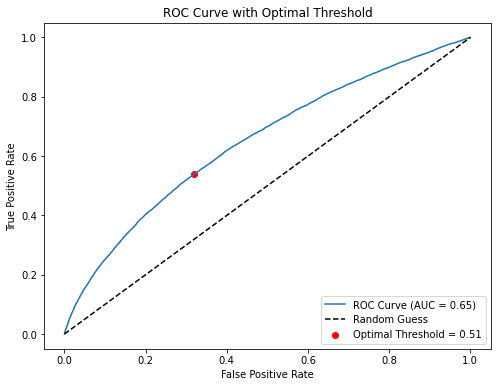

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score

# Assuming you already have y_test (true labels) and y_prob (predicted probabilities) from your model
# For example:
# y_prob = clf.predict_proba(X_test)[:, 1]
# y_test = actual labels for X_test

# Compute the ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC:", roc_auc)

# Calculate Youden's Index for each threshold and determine the optimal threshold
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold based on Youden's Index:", optimal_threshold)

# Generate new predictions using the optimal threshold
y_pred_opt = (y_prob >= optimal_threshold).astype(int)

# Evaluate the performance with the adjusted threshold
cm_opt = confusion_matrix(y_test, y_pred_opt)
print("Confusion Matrix with optimal threshold:")
print(cm_opt)

TN_opt, FP_opt, FN_opt, TP_opt = cm_opt.ravel()

# 计算敏感性（正类召回率）和特异性（负类召回率）
sensitivity_opt = TP_opt / (TP_opt + FN_opt)  # 真阳性率
specificity_opt = TN_opt / (TN_opt + FP_opt)    # 真阴性率

print("Optimal Threshold Sensitivity:", sensitivity_opt)
print("Optimal Threshold Specificity:", specificity_opt)

print("Classification Report with optimal threshold:")
print(classification_report(y_test, y_pred_opt))

# Plot the ROC curve and indicate the optimal threshold point
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o',
            label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Optimal Threshold")
plt.legend(loc="lower right")
plt.show()


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.7, SMOTE Ratio: 0.2
Confusion Matrix:
[[52900 26498]
 [ 5708  7057]]
Sensitivity: 0.553, Specificity: 0.666, AUC: 0.649
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.7, SMOTE Ratio: 0.3
Confusion Matrix:
[[52748 26650]
 [ 5715  7050]]
Sensitivity: 0.552, Specificity: 0.664, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.7, SMOTE Ratio: 0.4
Confusion Matrix:
[[52873 26525]
 [ 5735  7030]]
Sensitivity: 0.551, Specificity: 0.666, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.7, SMOTE Ratio: 0.5
Confusion Matrix:
[[52823 26575]
 [ 5740  7025]]
Sensitivity: 0.550, Specificity: 0.665, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.7, SMOTE Ratio: 0.6
Confusion Matrix:
[[52844 26554]
 [ 5747  7018]]
Sensitivity: 0.550, Specificity: 0.666, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.7, SMOTE Ratio: 0.7
Confusion Matrix:
[[52845 26553]
 [ 5750  7015]]
Sensitivity: 0.550, Specificity: 0.666, AUC: 0.647
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.8, SMOTE Ratio: 0.2
Confusion Matrix:
[[52940 26458]
 [ 5714  7051]]
Sensitivity: 0.552, Specificity: 0.667, AUC: 0.649
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.8, SMOTE Ratio: 0.3
Confusion Matrix:
[[52744 26654]
 [ 5724  7041]]
Sensitivity: 0.552, Specificity: 0.664, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.8, SMOTE Ratio: 0.4
Confusion Matrix:
[[52841 26557]
 [ 5729  7036]]
Sensitivity: 0.551, Specificity: 0.666, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.8, SMOTE Ratio: 0.5
Confusion Matrix:
[[52868 26530]
 [ 5745  7020]]
Sensitivity: 0.550, Specificity: 0.666, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.8, SMOTE Ratio: 0.6
Confusion Matrix:
[[52863 26535]
 [ 5758  7007]]
Sensitivity: 0.549, Specificity: 0.666, AUC: 0.647
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.8, SMOTE Ratio: 0.7
Confusion Matrix:
[[52825 26573]
 [ 5743  7022]]
Sensitivity: 0.550, Specificity: 0.665, AUC: 0.647
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.9, SMOTE Ratio: 0.2
Confusion Matrix:
[[52931 26467]
 [ 5712  7053]]
Sensitivity: 0.553, Specificity: 0.667, AUC: 0.649
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.9, SMOTE Ratio: 0.3
Confusion Matrix:
[[52705 26693]
 [ 5726  7039]]
Sensitivity: 0.551, Specificity: 0.664, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.9, SMOTE Ratio: 0.4
Confusion Matrix:
[[52816 26582]
 [ 5719  7046]]
Sensitivity: 0.552, Specificity: 0.665, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.9, SMOTE Ratio: 0.5
Confusion Matrix:
[[52746 26652]
 [ 5728  7037]]
Sensitivity: 0.551, Specificity: 0.664, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.9, SMOTE Ratio: 0.6
Confusion Matrix:
[[52892 26506]
 [ 5758  7007]]
Sensitivity: 0.549, Specificity: 0.666, AUC: 0.648
----------------------------------------


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Under Ratio: 0.9, SMOTE Ratio: 0.7
Confusion Matrix:
[[52889 26509]
 [ 5759  7006]]
Sensitivity: 0.549, Specificity: 0.666, AUC: 0.647
----------------------------------------


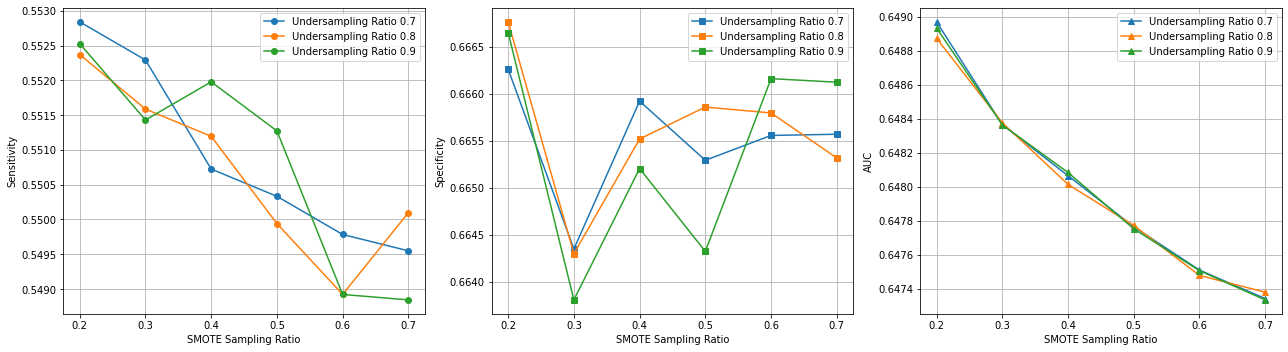

Current Model AUC: 0.6489685643377501
Optimal Threshold based on Youden's Index: 0.5070629852498452
Sensitivity at Optimal Threshold: 0.5400705052878966
Specificity at Optimal Threshold: 0.6807980049875312


d:\Anaconda3\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


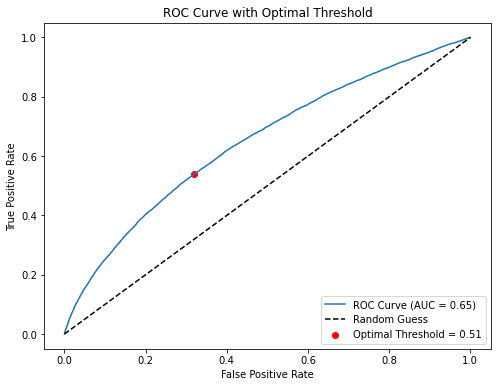

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# ---------------------------
# Step 1: Data Preparation
# ---------------------------
# Use final predictors from the AIC selection (ensure column names match those in the DataFrame)
final_predictors = [
    "SEX", "_AGE_GROUP", "_RACEGR3", "_EDUCA_GROUP", "_INCOM_GROUP",
    "_SMOKER3_GROUP", "_BMI5CAT", "_FRTLT1A", "_VEGLT1A", 
    "_TOTINDA", "_RFBING5", "_ECIGSTS_GROUP", "_PHYS14D", 
    "_MENT14D", "CHECKUP1_GROUP"
]

# Create a subset with only the final predictors and the target variable, dropping any missing values.
df_final = df[final_predictors + ["_LTASTH1"]].dropna()

# ---------------------------
# Step 2: Split Data (Stratified)
# ---------------------------
X = df_final.drop(columns=["_LTASTH1"])
y = df_final["_LTASTH1"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ---------------------------
# Step 3: Set Up Imputation and Resampling Pipelines
# ---------------------------
imputer = SimpleImputer(strategy='most_frequent')

# Define lists of ratios to test for SMOTE and RandomUnderSampler
smote_ratios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
undersample_ratios = [0.7, 0.8, 0.9]

# Prepare dictionaries to store performance metrics for each combination
results = {}  # key: under_ratio, value: dictionary with lists for each smote_ratio

for under_ratio in undersample_ratios:
    sens_list = []
    spec_list = []
    auc_list = []
    for smote_ratio in smote_ratios:
        # Create SMOTE and RandomUnderSampler with current ratios
        over = SMOTE(sampling_strategy=smote_ratio, random_state=42)
        under = RandomUnderSampler(sampling_strategy=under_ratio, random_state=42)
        
        # Build the pipeline: imputation, then oversampling, then undersampling
        resample_pipeline = Pipeline(steps=[
            ('imputer', imputer),
            ('over', over),
            ('under', under)
        ])
        
        # Resample the training data
        X_train_res, y_train_res = resample_pipeline.fit_resample(X_train, y_train)
        
        # Train logistic regression model with balanced class weights
        clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        clf.fit(X_train_res, y_train_res)
        
        # Predict probabilities and classes on the test set
        y_prob = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        
        # Compute confusion matrix and performance metrics
        cm = confusion_matrix(y_test, y_pred)
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        auc_val = roc_auc_score(y_test, y_prob)
        
        sens_list.append(sensitivity)
        spec_list.append(specificity)
        auc_list.append(auc_val)
        
        print(f"Under Ratio: {under_ratio}, SMOTE Ratio: {smote_ratio}")
        print("Confusion Matrix:")
        print(cm)
        print(f"Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}, AUC: {auc_val:.3f}")
        print("-"*40)
    
    results[under_ratio] = {
        'smote_ratios': smote_ratios,
        'sensitivities': sens_list,
        'specificities': spec_list,
        'aucs': auc_list
    }

# ---------------------------
# Step 4: Plot Performance Metrics for Different Resampling Combinations
# ---------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for under_ratio in undersample_ratios:
    axs[0].plot(results[under_ratio]['smote_ratios'], results[under_ratio]['sensitivities'], marker='o', label=f"Undersampling Ratio {under_ratio}")
    axs[1].plot(results[under_ratio]['smote_ratios'], results[under_ratio]['specificities'], marker='s', label=f"Undersampling Ratio {under_ratio}")
    axs[2].plot(results[under_ratio]['smote_ratios'], results[under_ratio]['aucs'], marker='^', label=f"Undersampling Ratio {under_ratio}")

axs[0].set_xlabel("SMOTE Sampling Ratio")
axs[0].set_ylabel("Sensitivity")
axs[0].legend()
axs[0].grid(True)

axs[1].set_xlabel("SMOTE Sampling Ratio")
axs[1].set_ylabel("Specificity")
axs[1].legend()
axs[1].grid(True)

axs[2].set_xlabel("SMOTE Sampling Ratio")
axs[2].set_ylabel("AUC")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# ---------------------------
# Step 5: Threshold Adjustment for an Optimal Resampling Combination
# ---------------------------
# Choose an optimal combination 
optimal_smote_ratio = 0.2
optimal_under_ratio = 0.7

# Build resampling pipeline with the selected ratios
over = SMOTE(sampling_strategy=optimal_smote_ratio, random_state=42)
under = RandomUnderSampler(sampling_strategy=optimal_under_ratio, random_state=42)
resample_pipeline = Pipeline(steps=[
    ('imputer', imputer),
    ('over', over),
    ('under', under)
])

X_train_res, y_train_res = resample_pipeline.fit_resample(X_train, y_train)
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_res, y_train_res)

# Predict probabilities on the test set and compute ROC curve
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print("Current Model AUC:", roc_auc)

# Calculate Youden's Index to determine the optimal threshold
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold based on Youden's Index:", optimal_threshold)

# Generate new predictions using the optimal threshold
y_pred_opt = (y_prob >= optimal_threshold).astype(int)
cm_opt = confusion_matrix(y_test, y_pred_opt)
TN_opt, FP_opt, FN_opt, TP_opt = cm_opt.ravel()
sensitivity_opt = TP_opt / (TP_opt + FN_opt)
specificity_opt = TN_opt / (TN_opt + FP_opt)
print("Sensitivity at Optimal Threshold:", sensitivity_opt)
print("Specificity at Optimal Threshold:", specificity_opt)

# Plot the ROC curve with the optimal threshold indicated
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o',
            label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Optimal Threshold")
plt.legend(loc="lower right")
plt.show()


## Another Model

In [12]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from IPython.display import display

# Combine all variable lists
all_vars_list = lifestyle_vars + demographic_vars

# Clean all variable lists and center numerical variables (categorical variables remain unchanged)
all_vars_centered = []
for var in all_vars_list:
    if var.startswith("C(") and var.endswith(")"):  # Process categorical variables
        var_clean = var[2:-1]
        all_vars_centered.append(f"C({var_clean})")
    else:
        var_clean = var
        if pd.api.types.is_numeric_dtype(df[var_clean]):  # Center numerical variables
            centered_var = var_clean + "_centered"
            df[centered_var] = df[var_clean] - df[var_clean].mean()
            all_vars_centered.append(centered_var)
        else:
            all_vars_centered.append(var_clean)

# Generate interaction terms
def generate_interaction_terms(vars_list):
    return ["{}:{}".format(a, b) for a, b in itertools.combinations(vars_list, 2)]

# Construct the correct regression formula (including main effects + interaction terms)
formula_interactions = "_LTASTH1 ~ " + " + ".join(all_vars_centered + generate_interaction_terms(all_vars_centered))

# Run logistic regression, controlling for confounding factors
model_interactions = smf.logit(formula=formula_interactions, data=df).fit(cov_type='HC0')

# Construct results DataFrame and calculate OR, 95% confidence intervals, and Adjusted OR
summary_df = pd.DataFrame({
    "Variable": model_interactions.params.index,
    "Coefficient": model_interactions.params.values,
    "Std Err": model_interactions.bse.values,
    "z-score": model_interactions.tvalues,
    "p-value": model_interactions.pvalues
})
summary_df["OR"] = np.exp(summary_df["Coefficient"])  # Calculate odds ratio (OR)
ci = model_interactions.conf_int()
summary_df["2.5% CI"] = np.exp(ci.iloc[:, 0])
summary_df["97.5% CI"] = np.exp(ci.iloc[:, 1])

# ✅ **Calculate Adjusted OR to consistently measure deviation from 1**
summary_df["Adjusted OR"] = summary_df["OR"].apply(lambda x: max(x, 1/x))

# ✅ **Filter all interaction terms (variables containing ":")**
interaction_df = summary_df[summary_df["Variable"].str.contains(":")]

# ✅ **Select the top 20 interaction terms based on Adjusted OR**
top_20_interactions = interaction_df.nlargest(20, "Adjusted OR")

# ✅ **Final report DataFrame, sorted by Adjusted OR**
report_df = top_20_interactions[["Variable", "OR", "2.5% CI", "97.5% CI", "p-value", "Adjusted OR"]]
report_df[["OR", "2.5% CI", "97.5% CI", "p-value", "Adjusted OR"]] = report_df[["OR", "2.5% CI", "97.5% CI", "p-value", "Adjusted OR"]].round(3)
report_df = report_df.set_index("Variable").sort_values(by="Adjusted OR", ascending=False)  # ✅ **Sorting**

print("Top 20 interaction terms selected based on Adjusted OR (for reporting):")
display(report_df)


Optimization terminated successfully.
         Current function value: 0.379701
         Iterations 7
Top 20 interaction terms selected based on Adjusted OR (for reporting):


d:\Anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,OR,2.5% CI,97.5% CI,p-value,Adjusted OR
Variable,,,,,
C(_AGE_GROUP)[T.3]:C(_RACEGR3)[T.3.0],1.704,1.468,1.978,0.000,1.704
C(_RACEGR3)[T.5.0]:C(_EDUCA_GROUP)[T.2],1.598,1.398,1.825,0.000,1.598
C(_BMI5CAT)[T.2.0]:C(_VEGLT1A)[T.2.0],1.474,1.155,1.880,0.002,1.474
C(_BMI5CAT)[T.4.0]:C(SEX)[T.2.0],1.456,1.184,1.789,0.000,1.456
C(_AGE_GROUP)[T.2]:C(_RACEGR3)[T.3.0],1.443,1.276,1.632,0.000,1.443
C(_BMI5CAT)[T.3.0]:C(_RACEGR3)[T.4.0],1.439,0.867,2.390,0.159,1.439
C(_ECIGSTS_GROUP)[T.3]:C(_RACEGR3)[T.3.0],0.698,0.554,0.881,0.002,1.432
C(_SMOKER3_GROUP)[T.3]:C(_BMI5CAT)[T.4.0],1.384,1.071,1.789,0.013,1.384
C(_BMI5CAT)[T.4.0]:C(_VEGLT1A)[T.2.0],1.370,1.077,1.743,0.010,1.370


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import itertools
import re

import itertools
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from IPython.display import display

# Combine all variable lists
all_vars_list = lifestyle_vars + demographic_vars

# Clean all variable lists and center numerical variables (keep categorical variables unchanged)
all_vars_centered = []
for var in all_vars_list:
    if var.startswith("C(") and var.endswith(")"):  # Process categorical variables
        var_clean = var[2:-1]
        all_vars_centered.append(f"C({var_clean})")
    else:
        var_clean = var
        if pd.api.types.is_numeric_dtype(df[var_clean]):  # Center numerical variables
            centered_var = var_clean + "_centered"
            df[centered_var] = df[var_clean] - df[var_clean].mean()
            all_vars_centered.append(centered_var)
        else:
            all_vars_centered.append(var_clean)

# Generate interaction terms
def generate_interaction_terms(vars_list):
    return ["{}:{}".format(a, b) for a, b in itertools.combinations(vars_list, 2)]

# Correct regression formula (including main effects + interaction terms)
formula_interactions = "_LTASTH1 ~ " + " + ".join(all_vars_centered + generate_interaction_terms(all_vars_centered))


try:
    # Fit the logistic regression model and specify robust covariance type
    model_interactions = smf.logit(formula=formula_interactions, data=df).fit(cov_type='HC0')

    # Construct results DataFrame and calculate OR, 95% CI, and Adjusted OR
    summary_df = pd.DataFrame({
        "Variable": model_interactions.params.index,
        "Coefficient": model_interactions.params.values,
        "Standard Error": model_interactions.bse.values,
        "z-score": model_interactions.tvalues,
        "p-value": model_interactions.pvalues
    })
    summary_df["Odds Ratio (OR)"] = np.exp(summary_df["Coefficient"])
    ci = model_interactions.conf_int()
    summary_df["2.5% CI"] = np.exp(ci.iloc[:, 0])
    summary_df["97.5% CI"] = np.exp(ci.iloc[:, 1])
    # Adjusted OR: standardize the deviation from 1 (for OR < 1, take the reciprocal)
    summary_df["Adjusted OR"] = summary_df["Odds Ratio (OR)"].apply(lambda x: max(x, 1/x))

    # Filter all interaction terms (variables containing ":") and select the top 20 based on Adjusted OR
    interaction_df = summary_df[summary_df["Variable"].str.contains(":")]
    top_20_interactions = interaction_df.nlargest(20, "Adjusted OR")["Variable"].tolist()

    # Output model results and interaction term list
    report_df = summary_df[summary_df["Variable"].isin(top_20_interactions)][
        ["Variable", "Odds Ratio (OR)", "2.5% CI", "97.5% CI", "p-value", "Adjusted OR"]
    ]
    report_df[["Odds Ratio (OR)", "2.5% CI", "97.5% CI", "p-value", "Adjusted OR"]] = report_df[
        ["Odds Ratio (OR)", "2.5% CI", "97.5% CI", "p-value", "Adjusted OR"]
    ].round(3)
    report_df = report_df.set_index("Variable")

    print("Top 20 interaction terms selected based on Adjusted OR (for reporting):")
    print(report_df)

    # Extract variables involved in interaction terms and reconstruct interaction terms
    clean_interactions = []
    for term in top_20_interactions:
        # Split interaction terms into two variables
        parts = term.split(':')
        
        # Extract the base name of the first variable
        var1_match = re.match(r'C\((.*?)\)', parts[0])
        if var1_match:
            var1 = var1_match.group(1)
        else:
            var1 = parts[0]
            
        # Extract the base name of the second variable
        var2_match = re.match(r'C\((.*?)\)', parts[1])
        if var2_match:
            var2 = var2_match.group(1)
        else:
            var2 = parts[1]
            
        # Reconstruct a simpler interaction term
        clean_interaction = f"C({var1}):C({var2})"
        clean_interactions.append(clean_interaction)
        
    # Print reconstructed interaction terms before use
    print("Reconstructed interaction terms:")
    for term in clean_interactions:
        print(term)

    # Construct the final formula: main effects + reconstructed interaction terms
    final_formula = "_LTASTH1 ~ " + " + ".join(demographic_vars + lifestyle_vars + clean_interactions)
    print("Final formula:", final_formula)

    try:
        # Fit the final logistic regression model
        final_model = smf.logit(formula=final_formula, data=df).fit(cov_type='HC0', disp=0)
        print(final_model.summary())
    except Exception as e:
        print(f"Final model fitting failed: {e}")
        
        # If still failing, try adding interaction terms one by one
        print("Trying to validate interaction terms one by one...")
        valid_interactions = []
        
        # First, ensure that the main effects model can run
        base_formula = "_LTASTH1 ~ " + " + ".join(demographic_vars + lifestyle_vars)
        try:
            base_model = smf.logit(formula=base_formula, data=df).fit(cov_type='HC0', disp=0)
            print("Main effects model successfully fitted")
            
            # Test each interaction term individually
            for term in clean_interactions:
                test_formula = base_formula + " + " + term
                try:
                    test_model = smf.logit(formula=test_formula, data=df).fit(cov_type='HC0', disp=0)
                    valid_interactions.append(term)
                    print(f"Interaction term '{term}' is valid")
                except Exception as err:
                    print(f"Interaction term '{term}' is invalid: {err}")
            
            # Use all valid interaction terms
            if valid_interactions:
                final_formula = base_formula + " + " + " + ".join(valid_interactions)
                print("Final formula using valid interaction terms:", final_formula)
                final_model = smf.logit(formula=final_formula, data=df).fit(cov_type='HC0', disp=0)
                print(final_model.summary())
            else:
                print("No valid interaction terms, using main effects model:")
                print(base_model.summary())
                
        except Exception as base_err:
            print(f"Main effects model fitting failed: {base_err}")
            print("Trying to simplify the model...")
            # If the main effects model also fails, try using only part of the main effects
            simple_formula = "_LTASTH1 ~ " + demographic_vars[0]  # Start with one variable
            final_model = smf.logit(formula=simple_formula, data=df).fit(cov_type='HC0', disp=0)
            print("Simplified model:")
            print(final_model.summary())
            
except Exception as e:
    print(f"Interaction model fitting failed: {e}")
    # If the interaction model fails, directly use the main effects model
    final_formula = "_LTASTH1 ~ " + " + ".join(demographic_vars + lifestyle_vars)
    try:
        final_model = smf.logit(formula=final_formula, data=df).fit(cov_type='HC0', disp=0)
        print(final_model.summary())
    except Exception as main_e:
        print(f"Main effects model also failed: {main_e}")
        # Try the simplest model
        simple_formula = "_LTASTH1 ~ C(SEX)"
        final_model = smf.logit(formula=simple_formula, data=df).fit(cov_type='HC0', disp=0)
        print("Simplest model:")
        print(final_model.summary())


Optimization terminated successfully.
         Current function value: 0.379701
         Iterations 7
Top 20 interaction terms selected based on Adjusted OR (for reporting):
                                               Odds Ratio (OR)  2.5% CI  \
Variable                                                                  
C(_SMOKER3_GROUP)[T.3]:C(_BMI5CAT)[T.3.0]                1.363    1.053   
C(_SMOKER3_GROUP)[T.3]:C(_BMI5CAT)[T.4.0]                1.384    1.071   
C(_SMOKER3_GROUP)[T.2]:C(_ECIGSTS_GROUP)[T.3]            1.317    1.153   
C(_SMOKER3_GROUP)[T.3]:C(_INCOM_GROUP)[T.3]              1.332    1.196   
C(_BMI5CAT)[T.2.0]:C(_VEGLT1A)[T.2.0]                    1.474    1.155   
C(_BMI5CAT)[T.3.0]:C(_VEGLT1A)[T.2.0]                    1.354    1.063   
C(_BMI5CAT)[T.4.0]:C(_VEGLT1A)[T.2.0]                    1.370    1.077   
C(_BMI5CAT)[T.4.0]:C(_ECIGSTS_GROUP)[T.2]                0.758    0.522   
C(_BMI5CAT)[T.2.0]:C(CHECKUP1_GROUP)[T.2]                1.291    1.052   
C

## Adjust the Threshold and evaluate the model to find the optimal Threshold based on Youden's J statistic

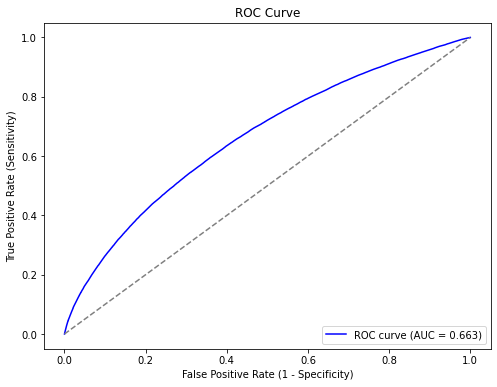

Model AUC: 0.663
Confusion Matrix:
[[264459    200]
 [ 42347    202]]
Accuracy: 0.862
Sensitivity (Recall): 0.005
Specificity: 0.999
   Threshold  Accuracy  Sensitivity  Specificity
0       0.10  0.469985     0.780841     0.420008
1       0.12  0.566245     0.681309     0.547746
2       0.13  0.611019     0.625796     0.608644
3       0.14  0.652216     0.568403     0.665691
4       0.15  0.683390     0.523632     0.709075
5       0.16  0.707976     0.484688     0.743874
6       0.17  0.731814     0.444852     0.777948
7       0.18  0.751956     0.406590     0.807481
8       0.20  0.781969     0.340807     0.852894
9       0.30  0.849639     0.122729     0.966504


In [14]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

# 1. Compute predicted probabilities
df["predicted_prob"] = final_model.predict(df)

# 2. Plot the ROC curve & calculate AUC
fpr, tpr, thresholds = roc_curve(df["_LTASTH1"], df["predicted_prob"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Reference line for random classification
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

print(f"Model AUC: {roc_auc:.3f}")

# 3. Compute confusion matrix with the default threshold of 0.5
threshold = 0.5  # Default threshold
df["predicted_class"] = (df["predicted_prob"] >= threshold).astype(int)

conf_matrix = confusion_matrix(df["_LTASTH1"], df["predicted_class"])
accuracy = accuracy_score(df["_LTASTH1"], df["predicted_class"])
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])  # TP / (TP + FN)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # TN / (TN + FP)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# 4. Test different thresholds and observe performance changes
thresholds_to_test = [0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.2, 0.3]
results = []

for t in thresholds_to_test:
    df["predicted_class"] = (df["predicted_prob"] >= t).astype(int)
    conf_matrix = confusion_matrix(df["_LTASTH1"], df["predicted_class"])
    acc = accuracy_score(df["_LTASTH1"], df["predicted_class"])
    sens = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    spec = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    results.append({"Threshold": t, "Accuracy": acc, "Sensitivity": sens, "Specificity": spec})

# Convert to DataFrame and display results
threshold_results = pd.DataFrame(results)
print(threshold_results)


Optimal threshold (based on Youden's index): 0.1349
Confusion matrix at the optimal threshold:
[[169680  94979]
 [ 17236  25313]]
Sensitivity : 0.5949
Specificity : 0.6411
Classification report at the optimal threshold:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75    264659
           1       0.21      0.59      0.31     42549

    accuracy                           0.63    307208
   macro avg       0.56      0.62      0.53    307208
weighted avg       0.81      0.63      0.69    307208

AUC: 0.663


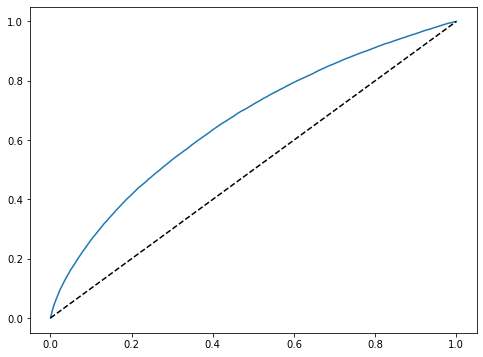

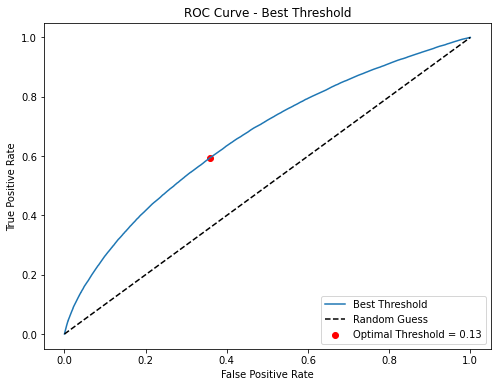

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# 1. Compute predicted probabilities (ensure that final_model is fitted and df contains all required variables)
df['pred_prob'] = final_model.predict(df)

# 2. Compute ROC curve data
fpr, tpr, thresholds = roc_curve(df['_LTASTH1'], df['pred_prob'])

# 3. Calculate Youden's index: J = sensitivity - (1 - specificity) = tpr - fpr
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print("Optimal threshold (based on Youden's index): {:.4f}".format(best_threshold))

# 4. Generate predicted classes based on the optimal threshold
df['pred_class_optimal'] = (df['pred_prob'] >= best_threshold).astype(int)

# 5. Compute the confusion matrix and extract TN, FP, FN, TP to calculate sensitivity and specificity
cm_optimal = confusion_matrix(df['_LTASTH1'], df['pred_class_optimal'])
print("Confusion matrix at the optimal threshold:")
print(cm_optimal)

TN, FP, FN, TP = cm_optimal.ravel()
sensitivity = TP / (TP + FN)  # Sensitivity (True Positive Rate)
specificity = TN / (TN + FP)  # Specificity (True Negative Rate)
print("Sensitivity : {:.4f}".format(sensitivity))
print("Specificity : {:.4f}".format(specificity))

print("Classification report at the optimal threshold:")
print(classification_report(df['_LTASTH1'], df['pred_class_optimal']))

print("AUC: {:.3f}".format(roc_auc))

# 6. Plot the ROC curve
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label="Chance")



plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Best Threshold')
plt.plot([0,1],[0,1],'k--', label="Random Guess")
plt.scatter(fpr[ix], tpr[ix], color='red', marker='o',
            label=f"Optimal Threshold = {best_threshold:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Threshold")
plt.legend(loc="lower right")
plt.show()





d:\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Target variable distribution before resampling:
0    264659
1     42549
Name: _LTASTH1, dtype: int64

Target variable distribution after resampling:
0    75615
1    52931
Name: _LTASTH1, dtype: int64
Optimal threshold (based on Youden's index): 0.4211
Confusion matrix at the optimal threshold:
[[15877  6808]
 [ 7321  8558]]
Sensitivity : 0.5390
Specificity : 0.6999
Classification report at the optimal threshold:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69     22685
           1       0.56      0.54      0.55     15879

    accuracy                           0.63     38564
   macro avg       0.62      0.62      0.62     38564
weighted avg       0.63      0.63      0.63     38564

AUC: 0.662


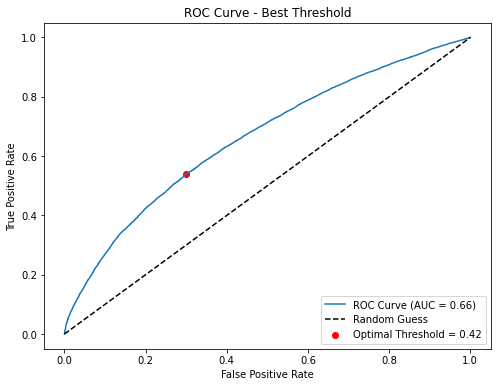

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report, auc

# Assume the dataset is already loaded into df, with the target variable '_LTASTH1'
X = df.drop('_LTASTH1', axis=1)
y = df['_LTASTH1']

# Construct a pipeline: Missing value imputation, SMOTE oversampling, RandomUnderSampler undersampling
imputer = SimpleImputer(strategy='mean')
over = SMOTE(sampling_strategy=0.2, random_state=42)         # Adjustable ratio
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Adjustable ratio
resample_pipeline = Pipeline(steps=[
    ('imputer', imputer),
    ('over', over),
    ('under', under)
])

# Perform resampling to balance the dataset
X_resampled, y_resampled = resample_pipeline.fit_resample(X, y)

# Print target variable distribution before and after resampling
print("Target variable distribution before resampling:")
print(y.value_counts())
print("\nTarget variable distribution after resampling:")
print(pd.Series(y_resampled).value_counts())

# Split the resampled data into training and testing sets (maintaining class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Fit logistic regression model
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]  # Predicted probability for the positive class

# Compute ROC curve data based on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute Youden's index: J = sensitivity - (1 - specificity) = tpr - fpr
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print("Optimal threshold (based on Youden's index): {:.4f}".format(best_threshold))

# Generate predicted classes using the optimal threshold
y_pred_optimal = (y_prob >= best_threshold).astype(int)

# Compute confusion matrix and evaluate sensitivity and specificity
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
print("Confusion matrix at the optimal threshold:")
print(cm_optimal)

TN, FP, FN, TP = cm_optimal.ravel()
sensitivity = TP / (TP + FN)  # Sensitivity (True Positive Rate)
specificity = TN / (TN + FP)  # Specificity (True Negative Rate)
print("Sensitivity : {:.4f}".format(sensitivity))
print("Specificity : {:.4f}".format(specificity))

print("Classification report at the optimal threshold:")
print(classification_report(y_test, y_pred_optimal))

# Compute AUC score
roc_auc = auc(fpr, tpr)
print("AUC: {:.3f}".format(roc_auc))

# Plot ROC curve with the optimal threshold marked
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.scatter(fpr[ix], tpr[ix], color='red', marker='o',
            label="Optimal Threshold = {:.2f}".format(best_threshold))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Threshold")
plt.legend(loc="lower right")
plt.show()
